# SMCNOD
This notebook presents the mixture model of 3 gaussians built for SMCNOD data. The data is taken from the S5 Collaboration. With quality cut, we obtained 371 stars with good measurements to feed the model. The mixture model is built with 16 parameters, including radial velocity, metallicity and proper motion parameters of the smcnod and a set of parameters for the background components. We fit a Gaussian mixture model to this data using `emcee`.

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## SMCNOD Data

In [2]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10

high_quality = (c1 | c2) & c3 & c4 & c6
table_cut = table_cut[high_quality]
tab = table_cut

In [75]:
import pandas as pd

nan_count = pd.isna(tab['pmra_pmdec_corr']).sum()

print("Number of NaN values in 'pmra_pmdec_corr':", nan_count)

Number of NaN values in 'pmra_pmdec_corr': 0


In [3]:
len(tab)

291

In [4]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

Text(0.5, 0, 'pmdec')

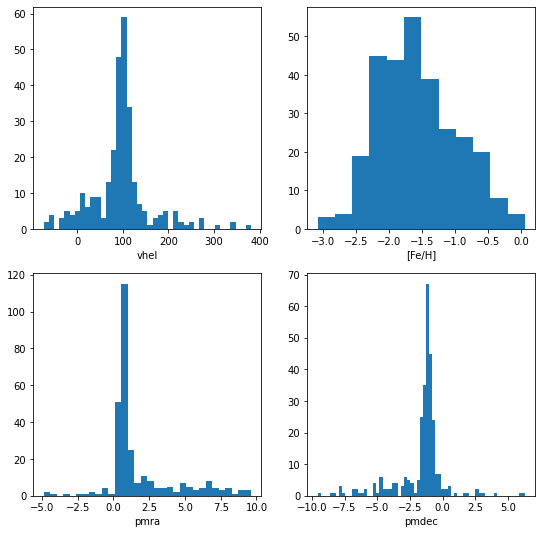

In [5]:
fig, axes = plt.subplots(2,2,figsize=(9,9))
axes[0,0].hist(rv, bins='auto');
axes[0,0].set_xlabel("vhel")
axes[0,1].hist(feh, bins='auto');
axes[0,1].set_xlabel("[Fe/H]")
axes[1,0].hist(pmra, bins='auto');
axes[1,0].set_xlabel("pmra")
axes[1,1].hist(pmdec, bins='auto');
axes[1,1].set_xlabel("pmdec")

In the given code, pmnorm is defined as 1/(np.pi * pmmax**2), where pmmax is the magnitude of the maximum proper motion vector. This expression is used to normalize the proper motion likelihood function for the entire data set.

In more detail, the proper motion likelihood function represents the probability of observing a particular proper motion vector for a star, given its position on the sky and any other relevant information. In this code, a uniform background distribution is assumed, which means that the likelihood of observing any particular proper motion vector is assumed to be constant across the entire sky.

To normalize the proper motion likelihood function, the maximum value of the proper motion vector magnitude is computed (pmmax), and the inverse of the product of pi and the square of pmmax is taken (1/(np.pi * pmmax**2)). This value (pmnorm) is then used to scale the proper motion likelihood function so that its integral over the entire sky is equal to one. This ensures that the probability of observing any proper motion vector is properly normalized, given the assumptions made in the analysis.

In [14]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
# pms array is computed and assigned to the variable pmmax. 
# This is essentially finding the magnitude of the maximum proper motion vector.
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
# normalize the proper motion likelihood function for the entire data set
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]

We will model the smcnod data as a mixture of 3 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pbg1 = fraction of stars in the 1st background component
* pmra = Heliocentric proper motion, RA of the galaxy in mas/yr
* pmdec = Heliocentric proper motion, Dec of the galaxy in mas/yr
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component
* vbg2, lsigvbg2, fehbg2, lsigfeh2 = same parameters for 2nd background component

In total there are 16 parameters.

# Likelihood function

In [15]:
#use a dictionary to store data, make the code more organized, easier to read, and more flexible.
data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [16]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2",
                "pmra","pmdec","pmra1","pmdec1","pmra2","pmdec2"]
def full_like(theta):
    """ Likelihood and Prior """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal, pmra1, pmdec1, \
    pmra2, pmdec2 = theta
    
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    pm1s = np.zeros((N,2))
    pm1s[:,0] = pmra1
    pm1s[:,1] = pmdec1
    
    pm2s = np.zeros((N,2))
    pm2s[:,0] = pmra2
    pm2s[:,1] = pmdec2
    
    # The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 400) or (vhel < -100) or (vbg1 > 500) or (vbg1 < 50) or \
        (vbg2 > 50) or (vbg2 < -50) or (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2) or \
        (abs(pmra1) > 10) or (abs(pmdec1) > 10) or (abs(pmra2) > 10) or (abs(pmdec2) > 10):
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    # Compute log likelihood in proper motions
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]
    lbg1_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm1s[i], cov=pmcovs[i]) for i in range(N)]
    lbg2_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm2s[i], cov=pmcovs[i]) for i in range(N)]

    
    # Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_pm + lgal_feh
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_pm + lbg1_feh
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_pm + lbg2_feh
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal) +lbgtot)
    return ltot.sum()

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

In [17]:
def project_model(theta, rvmin=-100, rvmax=400, fehmin=-3, fehmax=0):
    """ Turn parameters into rv and feh distributions """
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    #pmraarr = np.linspace(pmramin, pmramax, 1000)
    #pmdecarr = np.linspace(pmdecmin, pmdecmax, 1000)
    
    params = get_paramdict(theta)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    prv2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(rvarr, loc=params["vbg2"], scale=10**params["lsigvbg2"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    pfe2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(feharr, loc=params["fehbg2"], scale=10**params["lsigfeh2"])
    return rvarr, prv0, prv1, prv2,feharr, pfe0, pfe1, pfe2

def plot_1d_distrs(theta):
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins=200)
    xp, p0, p1, p2 = model_output[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="vhel (km/s)", ylabel="Prob. Density")
    ax.legend(fontsize='small')

    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="[Fe/H] (dex)", ylabel="Prob. Density")

    return fig

def plot_2d_distr(theta):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))
    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg2"], params["vbg2"],
               xerr=2*10**params["lsigfeh2"], yerr=2*10**params["lsigvbg2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999)

    ax.grid()

# Optimize parameters



In [18]:
p0_guess = [0.5, 0.5,
            102, 1.3, -1.9,-0.5,
            140, 2.0, -1.3, -0.37,
            27, 1.6, -0.7, -0.5,
            0.7, -1.1,
            1, -1,
            3, -2]

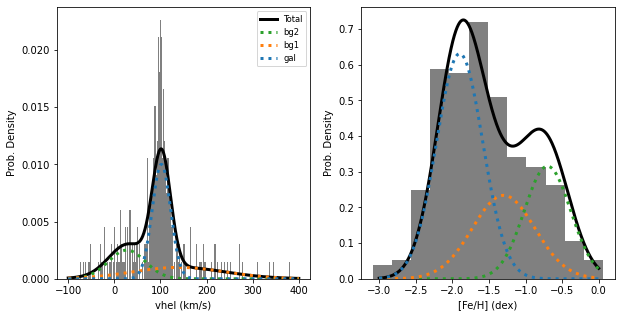

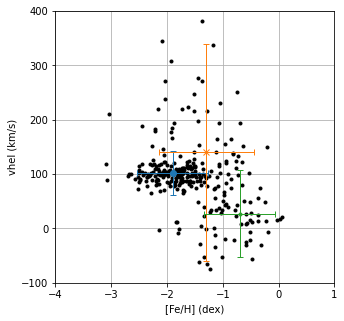

In [11]:
fig1 = plot_1d_distrs(p0_guess)
fig2 = plot_2d_distr(p0_guess)

In [19]:
optfunc = lambda theta: -full_like(theta)

In [20]:
%timeit optfunc(p0_guess)

90.7 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
optfunc(p0_guess)

66832.48873862167

In [22]:
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")

CPU times: user 6min 1s, sys: 1.6 s, total: 6min 3s
Wall time: 6min 1s


In [23]:
res.x

array([ 6.80644322e-01,  6.45466854e-02,  9.08786883e+01,  1.80299253e+00,
       -1.68456431e+00, -3.82864938e-01,  1.02381258e+02,  1.89461512e+00,
       -1.06266279e+00, -8.87633573e-01,  1.60439421e+01,  2.27433808e+00,
       -9.12697590e-01,  5.33301517e-01,  1.70668079e-01, -1.68077892e+00,
        2.09215040e+00,  1.81975169e+00,  6.69946316e+00,  1.30196795e-01])

In [24]:
optfunc(res.x)

39840.24951163034

In [25]:
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

pgal: 0.681
pbg1: 0.065
vhel: 90.879
lsigv: 1.803
feh: -1.685
lsigfeh: -0.383
vbg1: 102.381
lsigvbg1: 1.895
fehbg1: -1.063
lsigfeh1: -0.888
vbg2: 16.044
lsigvbg2: 2.274
fehbg2: -0.913
lsigfeh2: 0.533
pmra: 0.171
pmdec: -1.681
pmra1: 2.092
pmdec1: 1.820
pmra2: 6.699
pmdec2: 0.130


## Posterior Sampling
The posterior is sampled using `emcee` with 64 walkers and 10,000 steps per chain.

In [26]:
nparams = len(param_labels)
print(nparams)
nw = 64
p0 = res.x
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nw)
## Check to see things are initialized ok
lkhds = [full_like(p0s[j]) for j in range(nw)]
assert np.all(np.array(lkhds) > -9e9)

20


In [27]:
print(p0s)

[[6.77584422e-01 3.89303153e-02 9.08666223e+01 ... 1.80730524e+00
  6.69766816e+00 1.57716126e-01]
 [6.72852452e-01 6.20180684e-02 9.08854481e+01 ... 1.82319488e+00
  6.73211671e+00 1.24795612e-01]
 [6.78141011e-01 9.39336735e-02 9.09003039e+01 ... 1.81488476e+00
  6.69152082e+00 1.36693822e-01]
 ...
 [7.07945985e-01 8.57903977e-02 9.09011746e+01 ... 1.78810052e+00
  6.68837474e+00 1.51583905e-01]
 [6.81065330e-01 6.45208899e-02 9.08802345e+01 ... 1.82259636e+00
  6.65684187e+00 1.39582043e-01]
 [6.76665751e-01 8.49872751e-02 9.09090101e+01 ... 1.76885469e+00
  6.70428173e+00 1.46220314e-01]]


In [28]:
## Run emcee in parallel

from schwimmbad import MultiPool

nproc = 32 # use 32 cores
nit = 2000 # number of iterations for the MCMC sampling

def get_rstate():
    """
    Returns a random number generator with a random seed between assigned values
    """
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))

with MultiPool(nproc) as pool:
    print("Running burnin with {} iterations".format(nit))
    start = time.time()
    es = emcee.EnsembleSampler(nw, len(p0_guess), full_like, pool=pool)
    PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
    print("Took {:.1f} seconds".format(time.time()-start))

    print(f"Now running the actual thing")
    es.reset()
    start = time.time()
    es.run_mcmc(PP.coords, nit, rstate0=get_rstate())
    np.save("2NormalBG_old.npy",es.flatchain)
    print("Took {:.1f} seconds".format(time.time()-start))

Running burnin with 2000 iterations
Took 749.4 seconds
Now running the actual thing
Took 741.7 seconds


In [29]:
outputs = es.flatchain

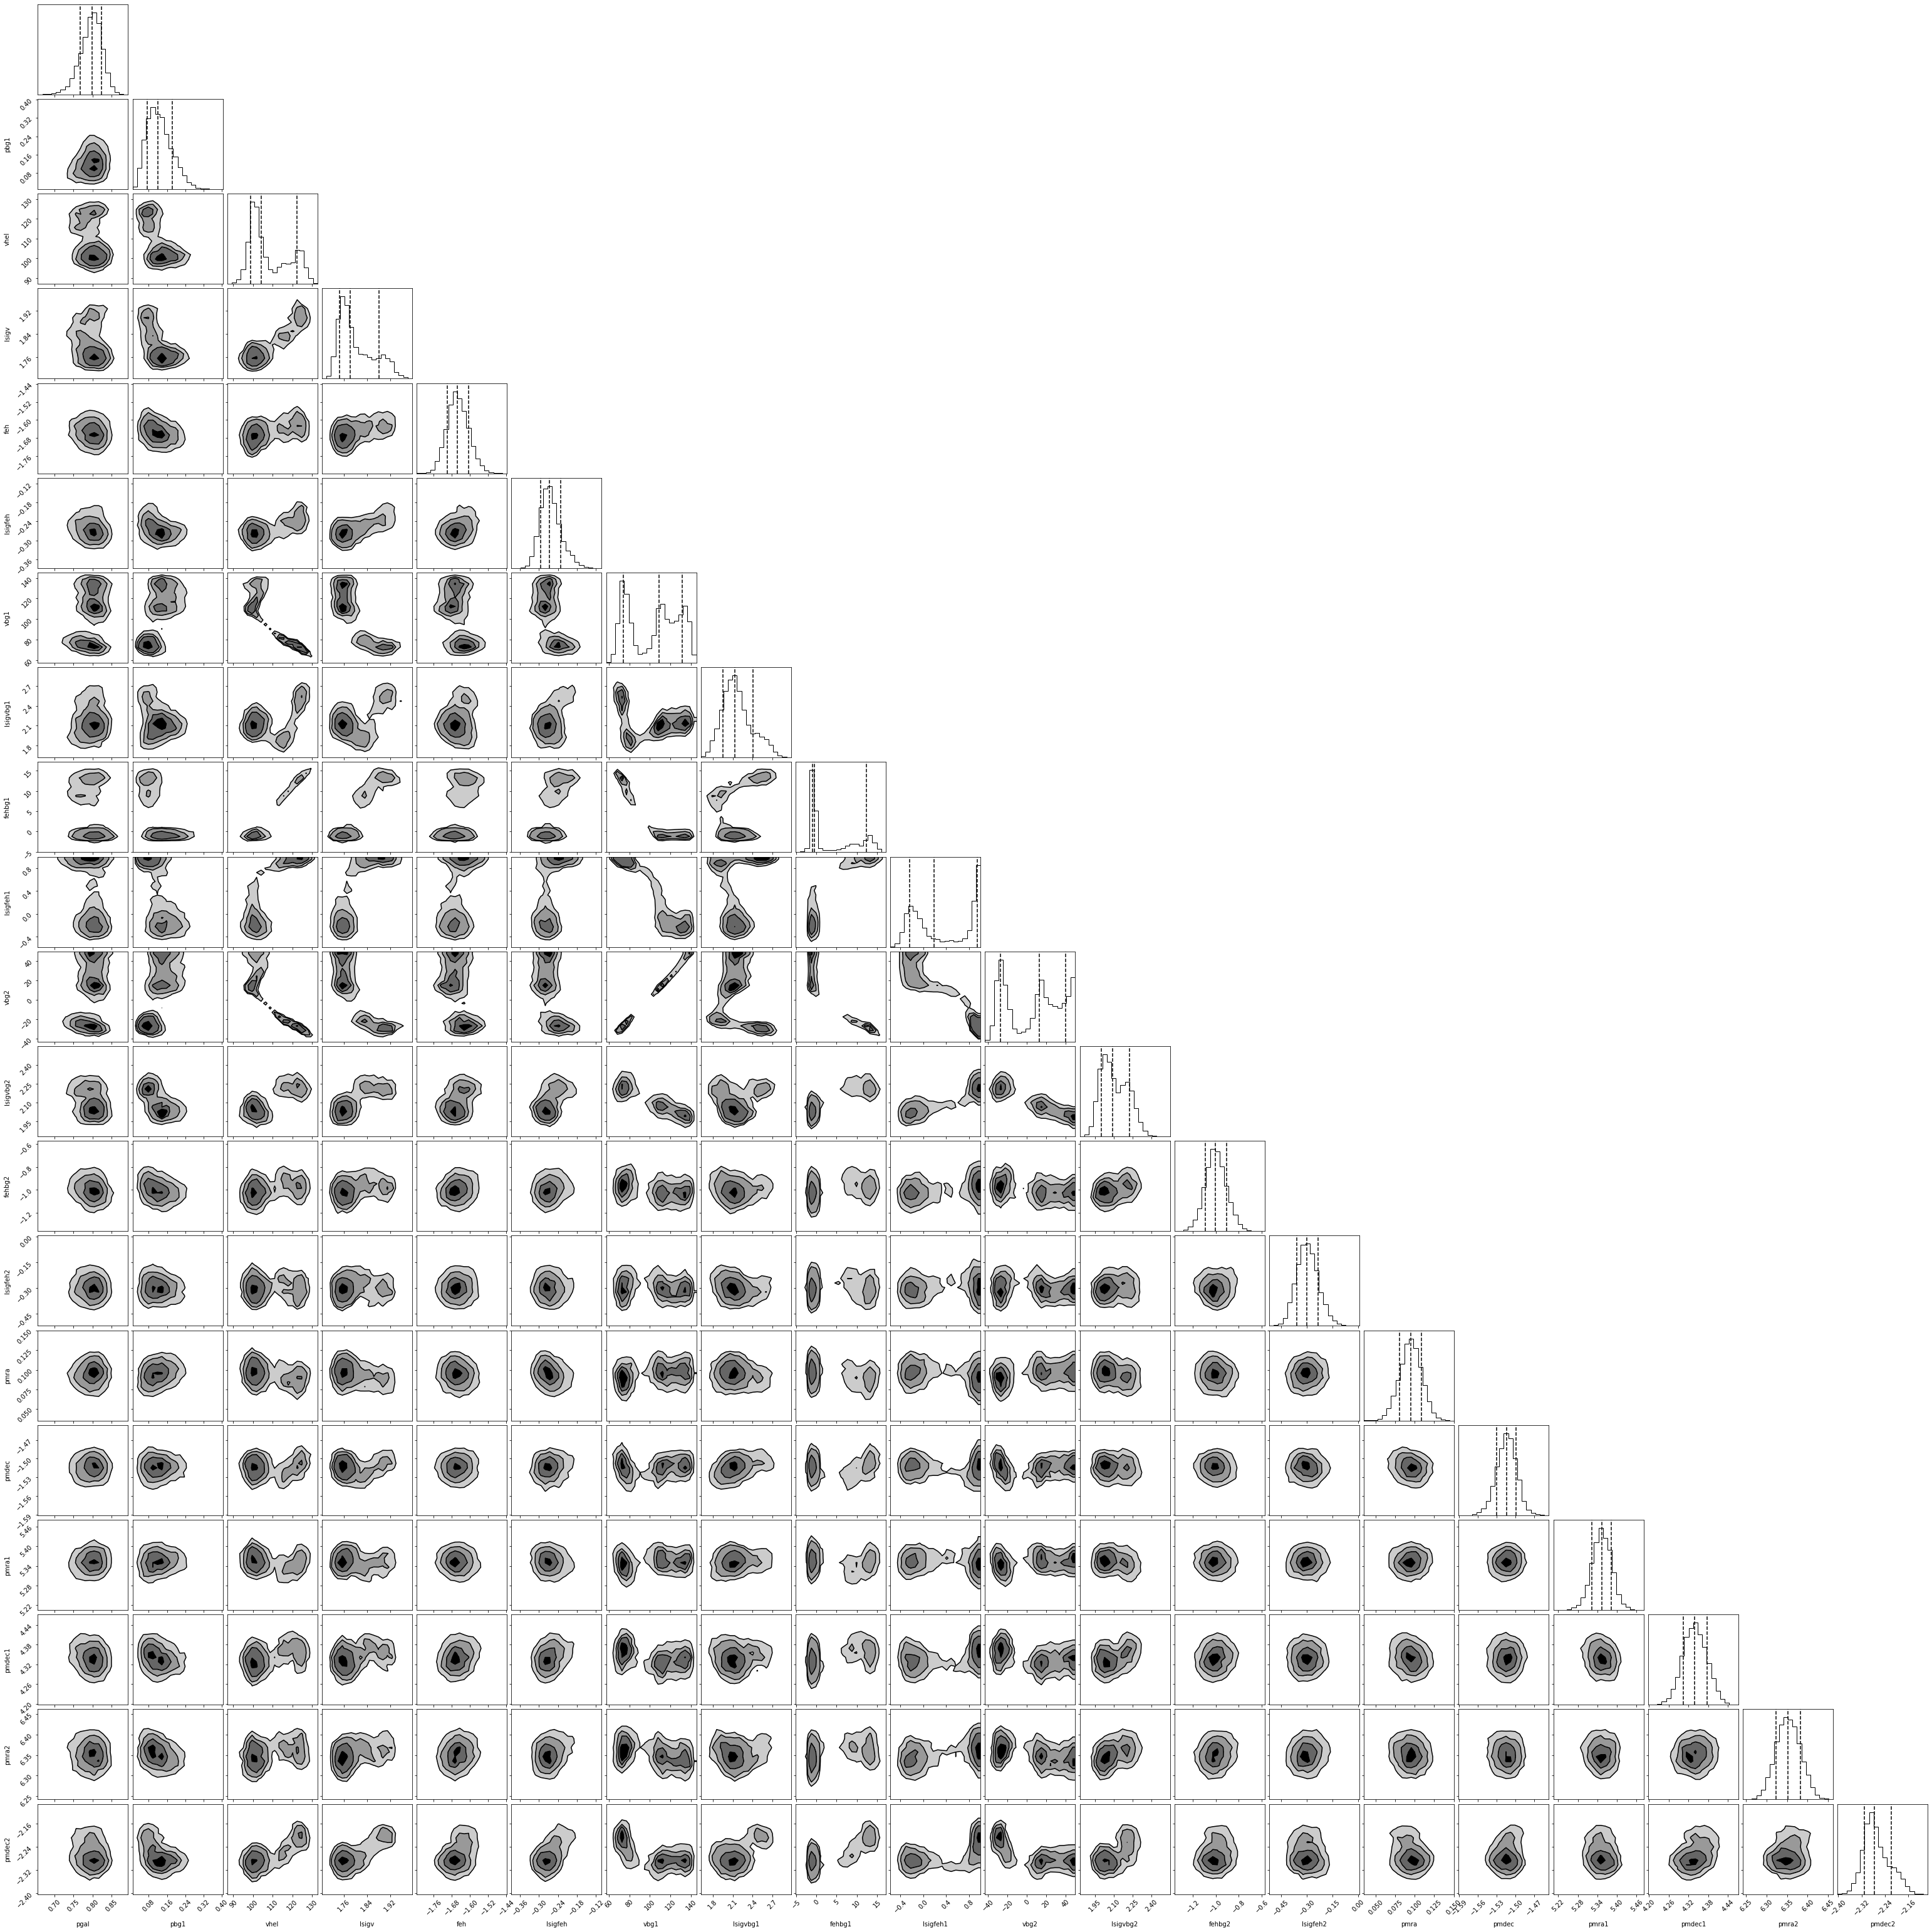

In [30]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})
plt.savefig('2NormalBG_newcov_Cornerplot.png')

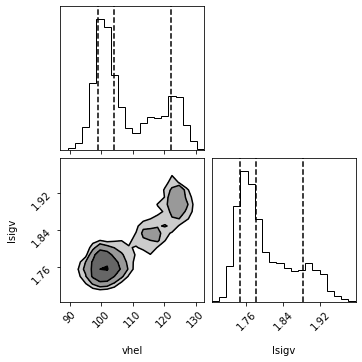

In [31]:
fig1 = corner.corner(outputs[:,2:4], labels=param_labels[2:4], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

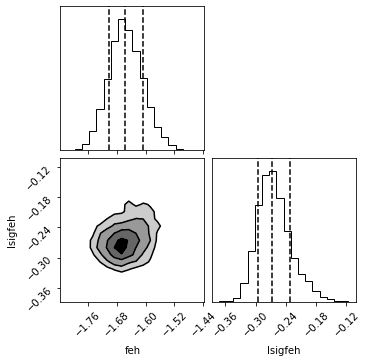

In [32]:
fig2 = corner.corner(outputs[:,4:6], labels=param_labels[4:6], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

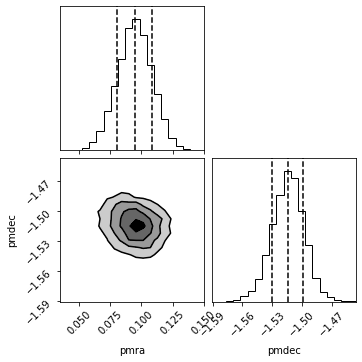

In [33]:
fig3 = corner.corner(outputs[:,14:16], labels=param_labels[14:16], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

In [34]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [35]:
meds, errs = process_chain(outputs)

In [36]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.798 0.028
pbg1 0.121 0.055
vhel 104.056 11.644
lsigv 1.781 0.068
feh -1.656 0.047
lsigfeh -0.267 0.032
vbg1 109.068 28.692
lsigvbg1 2.133 0.229
fehbg1 -0.476 6.697
lsigfeh1 0.183 0.593
vbg2 12.536 33.673
lsigvbg2 2.090 0.114
fehbg2 -1.002 0.091
lsigfeh2 -0.299 0.063
pmra 0.095 0.014
pmdec -1.514 0.016
pmra1 5.353 0.030
pmdec1 4.339 0.037
pmra2 6.352 0.030
pmdec2 -2.276 0.046


If things are well mixed, then you can just use the flat chain to concatenate all the walkers and steps.
The results here may not be perfectly mixed, but it's not terrible.
There are fancy ways to check things here involving autocorrelation times that Alex does not know about.
To me this is the hard part of emcee: knowing when you're happy with the result, and setting things up so that it gets there as fast as possible. This is why I prefer dynesty, even though it's slower it has a motivated stopping condition.

In [37]:
chain = es.flatchain
chain.shape

(128000, 20)

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

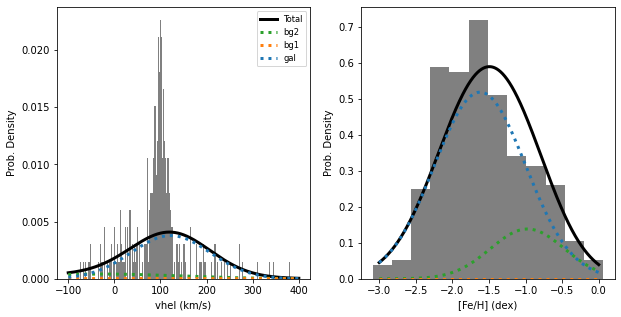

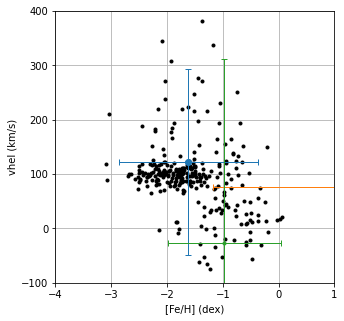

In [38]:
fig1 = plot_1d_distrs(chain[1])
fig2 = plot_2d_distr(chain[1])

In [39]:
chain_new = 10**(chain)
mean_vdisp = np.percentile(chain_new[:,3], 50)
std_vdisp = (np.percentile(chain_new[:,3], 84)-np.percentile(chain_new[:,3], 16))/2
mean_fehdisp = np.percentile(chain_new[:,5], 50)
std_fehdisp = (np.percentile(chain_new[:,5], 84)-np.percentile(chain_new[:,5], 16))/2
print("mean_vdisp: ",mean_vdisp, \
     "std_vdisp: ",std_vdisp)
print("mean_fehdisp: ",mean_fehdisp, \
     "std_fehdisp: ",std_fehdisp)

mean_vdisp:  60.45931117236361 std_vdisp:  10.200736735633445
mean_fehdisp:  0.5407304867669551 std_fehdisp:  0.039928410619734844


In [43]:
param_labels_1 = ["pgal = ","pbg1 = ",
                "vhel = ","lsigv = ","feh = ","lsigfeh = ",
                "vbg1 = ","lsigvbg1 = ","fehbg1 = ","lsigfeh1 = ",
                "vbg2 = ","lsigvbg2 = ","fehbg2 = ","lsigfeh2 = ",
                "pmra = ","pmdec = ",
                "pmra1 = ","pmdec1 = ",
                "pmra2 = ","pmdec2 = "]

def process_chain_1(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, err))
    else:
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, ep)), OrderedDict(zip(param_labels_1, em))

meds_1, errs_1 = process_chain_1(outputs)

for k,v in meds_1.items():
    print("{} {:.3f}".format(k, v))

pgal =  0.798
pbg1 =  0.121
vhel =  104.056
lsigv =  1.781
feh =  -1.656
lsigfeh =  -0.267
vbg1 =  109.068
lsigvbg1 =  2.133
fehbg1 =  -0.476
lsigfeh1 =  0.183
vbg2 =  12.536
lsigvbg2 =  2.090
fehbg2 =  -1.002
lsigfeh2 =  -0.299
pmra =  0.095
pmdec =  -1.514
pmra1 =  5.353
pmdec1 =  4.339
pmra2 =  6.352
pmdec2 =  -2.276


## Membership

In [44]:
# subjective peak selection for member
metalpoor = table_cut['feh50'] < -1.5
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] )  &  ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)
smcnod = table_cut[sel_peak][peak_pm]
tab_1 = smcnod
len(tab_1)

150

In [46]:
pgal =  0.798
pbg1 =  0.121
vhel =  104.056
lsigv =  1.781
feh =  -1.656
lsigfeh =  -0.267
vbg1 =  109.068
lsigvbg1 =  2.133
fehbg1 =  -0.476
lsigfeh1 =  0.183
vbg2 =  12.536
lsigvbg2 =  2.090
fehbg2 =  -1.002
lsigfeh2 =  -0.299
pmra =  0.095
pmdec =  -1.514
pmra1 =  5.353
pmdec1 =  4.339
pmra2 =  6.352
pmdec2 =  -2.276
theta_opt = pgal, pbg1, vhel, lsigv, feh, lsigfeh, vbg1, lsigvbg1, fehbg1, lsigfeh1, vbg2, lsigvbg2, fehbg2, lsigfeh2, pmra, pmdec,pmra1, pmdec1, pmra2, pmdec2

In [81]:
def memprob(theta):
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal, pmra1, pmdec1, \
    pmra2, pmdec2 = theta
    
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    pm1s = np.zeros((N,2))
    pm1s[:,0] = pmra1
    pm1s[:,1] = pmdec1
    
    pm2s = np.zeros((N,2))
    pm2s[:,0] = pmra2
    pm2s[:,1] = pmdec2
    
    #lgal
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))    
    ## Compute log likelihood in fe
    lgal_feh = stats.norm.logpdf(feh, loc=feh, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2)) 
    ## Compute log likelihood in pm
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh + lgal_pm
    ## exp of log
    gal = np.exp(lgal)
    
    ## bg1
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))   
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg1_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm1s[i], cov=pmcovs[i]) for i in range(N)]
    ## Combine the components
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh + lbg1_pm
    bg1 = np.exp(lbg1)
    
    # bg2
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    lbg2_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm2s[i], cov=pmcovs[i]) for i in range(N)]
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh + lbg2_pm
    bg2 = np.exp(lbg2)
    
    # combine bg1 and bg2
    lbgtot = np.logaddexp(lbg1, lbg2)
    bg = np.exp(lbgtot)
    
    # member probability
    # assign a value of 0 when dividing by zero or encountering NaN values
    p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)
    return p

In [82]:
sum((memprob(theta_opt) > 0.5))

/tmp/ipykernel_346137/2046274704.py:54: RuntimeWarning: invalid value encountered in true_divide
  p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)


228

In [68]:
# set the threshold to 0.5
tab['memberprob'] = memprob(theta_opt)
tab['membership'] = memprob(theta_opt) > 0.5
tab_good = tab[tab['memberprob'] > 0.5]

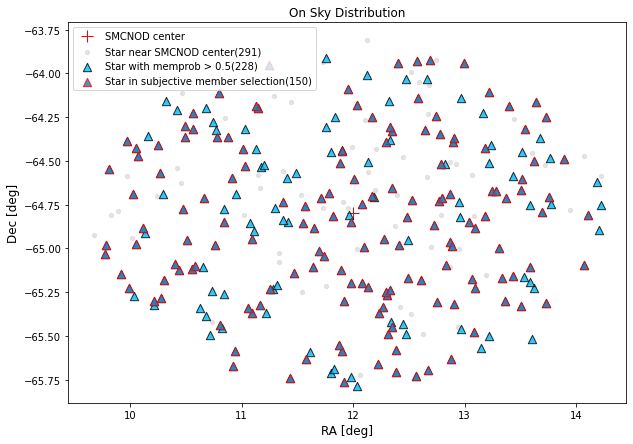

In [57]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='^', s=70, c='deepskyblue', ec='k', zorder=3, alpha=0.8,
        label='Star with memprob > 0.5(228)')
plt.scatter(tab_1['ra'],tab_1['dec'], marker='^', s=70, ec='r', zorder=3, alpha=0.8,
        label='Star in subjective member selection(150)')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()

In [58]:
# cut
g_band = tab['decam_g'] - 3.185 * tab['ebv']
r_band = tab['decam_r'] - 2.140 * tab['ebv']
i_band = tab['decam_i'] - 1.569 * tab['ebv']

g_cut = tab_good['decam_g'] - 3.185 * tab_good['ebv']
r_cut = tab_good['decam_r'] - 2.140 * tab_good['ebv']
i_cut = tab_good['decam_i'] - 1.569 * tab_good['ebv']

g_mem = tab_1['decam_g'] - 3.185 * tab_1['ebv']
r_mem = tab_1['decam_r'] - 2.140 * tab_1['ebv']
i_mem = tab_1['decam_i'] - 1.569 * tab_1['ebv']

table_iso = ascii.read('iso_a06.0_z0.00108.dat', header_start = 8)
g_iso = table_iso['DECam_g']
r_iso = table_iso['DECam_r']
# 18.96 ± 0.02 distance modulus in kpc
u_dm = 18.96

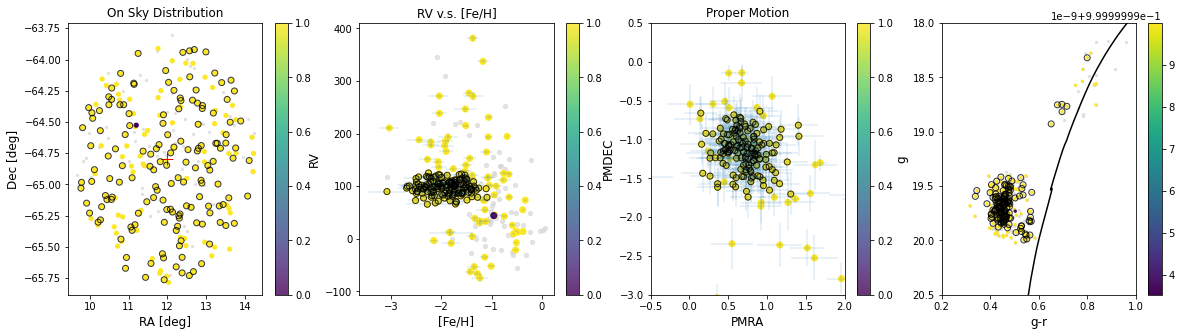

In [60]:
plt.figure(figsize=(20,5))
#plt.suptitle("Scatter Plot of Features", fontsize=20)
plt.subplot(1,4,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],
            marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['ra'],tab_good['dec'], 
            marker='.', s=70, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(228)')
plt.scatter(smcnod['ra'],smcnod['dec'], 
            marker='o',ec='k', zorder=3, facecolors='none', alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
#plt.legend()

plt.subplot(1,4,2)
plt.scatter(tab['feh50'],tab['vel_calib'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(228)')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], 
             fmt='None', marker='None',lw=0.2)
plt.scatter(smcnod['feh50'],smcnod['vel_calib'], 
            marker='o',ec='k', zorder=3, facecolors='none', alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
#plt.ylim(50,150)
plt.title('RV v.s. [Fe/H]')
#plt.legend()

plt.subplot(1,4,3)
plt.scatter(tab['pmra'],tab['pmdec'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(228)')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], 
             fmt='None', marker='None',lw=0.2)
plt.scatter(smcnod['pmra'],smcnod['pmdec'], 
            marker='o',ec='k', zorder=3, facecolors='none', alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
plt.xlim(-0.5,2)
plt.ylim(-3,0.5)
#plt.legend()

plt.subplot(1,4,4)
plt.scatter(g_band - r_band, g_band,marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.plot(g_iso - r_iso, g_iso + u_dm, '-k', label = 'Isochrone(Age=6Gyr, Z=0.001)')
plt.scatter(g_mem - r_mem, g_mem, 
            marker='o',ec='k', zorder=3, facecolors='none', alpha=0.8, label='Star in subjective member selection(150)')
plt.scatter(g_cut - r_cut, g_cut, marker='.', s=20, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(228)')

plt.xlim(0.2,1.0)
plt.ylim(18,20.5)
plt.xlabel('g-r', size = 12)
plt.ylabel('g', size = 12)
plt.gca().invert_yaxis()
#plt.legend()
plt.colorbar()
#plt.savefig('memberselect.png')
plt.show()